In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import random

In [2]:

class Value:

    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+') 

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*') 

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)) # Only supports int and float powers
        out = Value(self.data ** other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
 

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s |  data %.4f | grad % .4f }" %(n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [4]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.8633521456533618)

In [5]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
class Layer:
    
    def __init__(self, nin, nouts):
        self.neurons = [Neuron(nin) for _ in range(nouts)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs
    
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=-0.9649651458643782),
 Value(data=-0.9355037302032093),
 Value(data=0.9641417421830907)]

In [6]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nouts):
        self.neurons = [Neuron(nin) for _ in range(nouts)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [7]:
x = [2.0, 3.0, -1.0]
n = MLP(2, [4, 4, 1])
n(x)

Value(data=-0.9279518998107088)

In [8]:
n.parameters()

[Value(data=0.43245567017862174),
 Value(data=-0.1334955778926188),
 Value(data=-0.5951058138983016),
 Value(data=-0.4590308902845863),
 Value(data=0.7257325733828826),
 Value(data=-0.7097365823183017),
 Value(data=0.5751070057230101),
 Value(data=-0.16891186713494966),
 Value(data=-0.78720017593585),
 Value(data=0.18988170408724447),
 Value(data=-0.5628524141113627),
 Value(data=0.5770859867669311),
 Value(data=-0.19522405873828652),
 Value(data=0.212884573592119),
 Value(data=0.17073168114444592),
 Value(data=-0.8362441859583256),
 Value(data=-0.875967241967931),
 Value(data=0.412828310335537),
 Value(data=0.7027329387026209),
 Value(data=0.11457809402875063),
 Value(data=-0.1655615189564268),
 Value(data=0.7644477535385115),
 Value(data=0.1779590297036513),
 Value(data=-0.9690908809188923),
 Value(data=0.5410928469215495),
 Value(data=-0.2300955772134352),
 Value(data=-0.001047198416957995),
 Value(data=-0.7362749467676817),
 Value(data=-0.2450772831764778),
 Value(data=-0.183943307

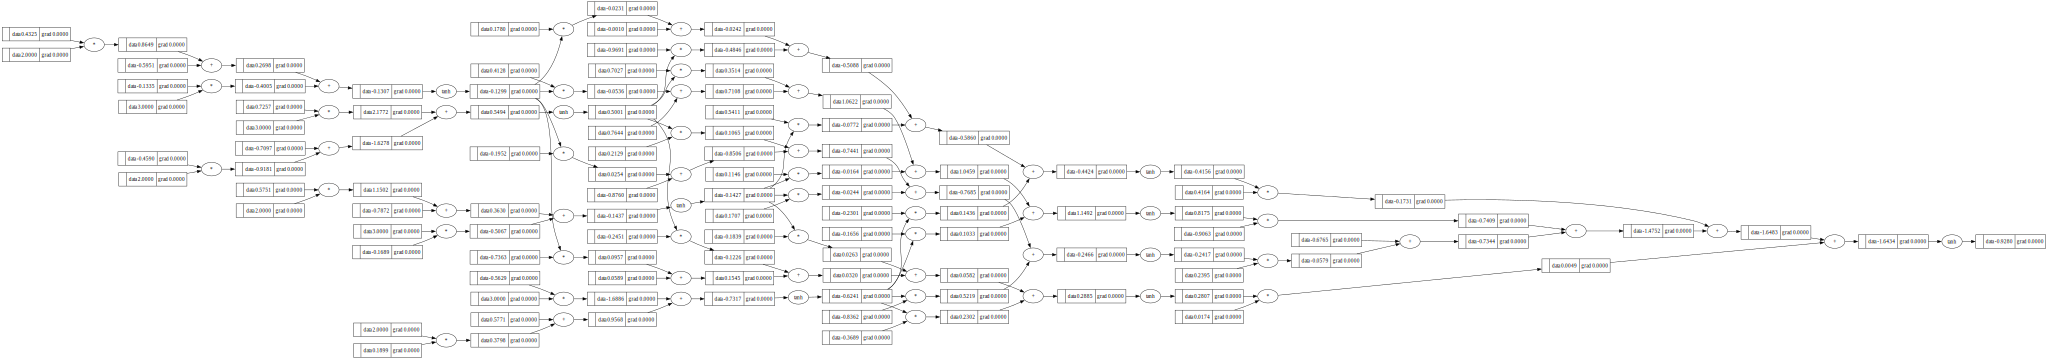

In [9]:
draw_dot(n(x))

In [ ]:
# Dataset

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, 0.5],
]

ys = [1.0, -1.0, -1.0, 1.0] # Desired targets



[Value(data=-0.9279518998107088),
 Value(data=-0.6687731089373645),
 Value(data=-0.8448197630670778),
 Value(data=-0.7880963138907803)]

In [ ]:
# Loss function

ypred = [n(x) for x in xs]
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
loss

Value(data=7.048079115031094)

In [131]:
for k in range(50):

    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))

    # Backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Update
    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)

0 1.4206114193984905e-10
1 1.4206114159385817e-10
2 1.4206114125385258e-10
3 1.4206114091086062e-10
4 1.4206114057085503e-10
5 1.4206114023043252e-10
6 1.4206113989002263e-10
7 1.4206113954743502e-10
8 1.4206113920702513e-10
9 1.4206113886143855e-10
10 1.4206113852102866e-10
11 1.4206113817844103e-10
12 1.4206113783803113e-10
13 1.420611374976086e-10
14 1.420611371571987e-10
15 1.4206113681461112e-10
16 1.4206113647420122e-10
17 1.4206113612861465e-10
18 1.4206113578820475e-10
19 1.4206113544561715e-10
20 1.4206113510520725e-10
21 1.4206113476478472e-10
22 1.4206113442437482e-10
23 1.4206113408436924e-10
24 1.4206113374137732e-10
25 1.4206113340095484e-10
26 1.4206113305578522e-10
27 1.420611327153753e-10
28 1.4206113237278772e-10
29 1.4206113203196087e-10
30 1.420611316919553e-10
31 1.4206113135154541e-10
32 1.420611310089578e-10
33 1.4206113066813096e-10
34 1.4206113032296137e-10
35 1.4206112998255147e-10
36 1.4206112963996387e-10
37 1.4206112929913702e-10
38 1.4206112895913149e-10
3

In [132]:
# After doing multiple iteration, the prediction value is almost same as the desired target
# When the loss is 0.0487641
ypred

[Value(data=0.9999981791016919),
 Value(data=-0.9999999999999208),
 Value(data=-0.9999883716091728),
 Value(data=0.9999981222403447)]